In [2]:
import json
import copy
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import keras_tuner
from dataclasses import dataclass
from typing import List
from keras import layers, ops
from keras.utils import timeseries_dataset_from_array
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PowerTransformer
from sklearn.linear_model import LinearRegression
from scipy.interpolate import griddata
%matplotlib inline

from processing import Stationarizer, Normalizer
from analysis import get_trials, get_RMSEs, make_histogram, plot_lrs, get_trials_df
from plotting import visualize_loss, show_plot
from model_builder import build_model, build_spec_model, get_tuner

2024-08-09 09:58:47.080978: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
trials = get_trials(186, "stock_predictor_2024-08-08 23:46:41.810675")
trials = get_RMSEs(trials)

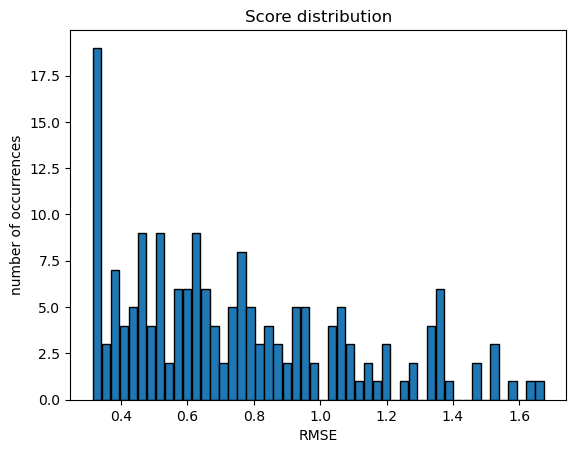

In [4]:
counts = make_histogram(trials, num_bins=50, width=0.025)

In [5]:
df = get_trials_df(trials)
df[:15]

,activation,kernel_initializer_0,dropout_0,recurrent_dropout_0,dropout_1,recurrent_dropout_1,kernel_initializer_1,lr,trial id,rmse,mse,best step,total dropout
0,tanh,glorot_normal,0.462673,0.210758,0.313560,0.070210,glorot_normal,0.000398,133,0.107102,0.011471,17,0.776233
1,linear,orthogonal,0.358192,0.048562,0.375983,0.032140,he_normal,0.000487,124,0.127077,0.016149,23,0.734175
2,linear,orthogonal,0.400637,0.046802,0.409050,0.110162,he_normal,0.000095,180,0.154016,0.023721,39,0.809687
3,linear,orthogonal,0.393503,0.219150,0.420513,0.080126,he_uniform,0.000720,167,0.157042,0.024662,18,0.814015
4,tanh,orthogonal,0.590092,0.231202,0.236492,0.223709,glorot_normal,0.000143,149,0.167694,0.028121,39,0.826584
5,tanh,orthogonal,0.428799,0.084549,0.278515,0.213912,he_uniform,0.000863,113,0.194078,0.037666,14,0.707314
6,linear,glorot_uniform,0.574897,0.155381,0.317766,0.139560,glorot_normal,0.000920,040,0.194509,0.037834,9,0.892663
7,tanh,glorot_uniform,0.324163,0.043207,0.461416,0.039362,glorot_uniform,0.000236,131,0.199317,0.039727,39,0.785579
8,tanh,glorot_normal,0.574929,0.224171,0.328598,0.046771,he_uniform,0.000638,132,0.224864,0.050564,12,0.903527
9,tanh,glorot_normal,0.483289,0.172218,0.219992,0.172276,he_normal,0.000393,172,0.228191,0.052071,19,0.703281


In [10]:
convergent = df[df["best step"] >= 32]
divergent = df[df["best step"] < 32]

Text(0.5, 1.0, 'Model RMSE vs. dropout rates')

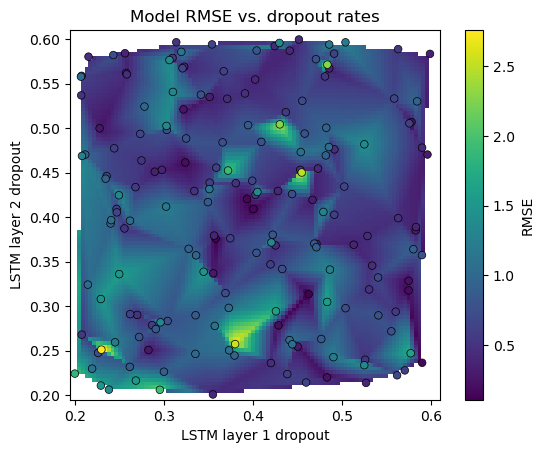

In [12]:
x = df.loc[:, "dropout_0"].to_numpy()
y = df.loc[:, "dropout_1"].to_numpy()
min_coord = 0.195 #min((min(x), min(y)))
max_coord = 0.61 #max((max(x), max(y)))
grid_x, grid_y = np.mgrid[min_coord:max_coord:100j, min_coord:max_coord:100j]
points = list(zip(x, y))
vals = df.loc[:, "rmse"]
grid_z = griddata(points, vals, (grid_x, grid_y), method="linear")
plt.imshow(grid_z.T, extent=(min_coord, max_coord, min_coord, max_coord), origin="lower")
plt.scatter(df.loc[:, "dropout_0"], df.loc[:, "dropout_1"], s=30, c=df.loc[:, "rmse"], marker="o", edgecolor="black", linewidth=0.5)
plt.xlabel("LSTM layer 1 dropout")
plt.ylabel("LSTM layer 2 dropout")
plt.colorbar(label="RMSE")
plt.title("Model RMSE vs. dropout rates")

Text(0.5, 1.0, 'Model RMSE vs. dropout rates')

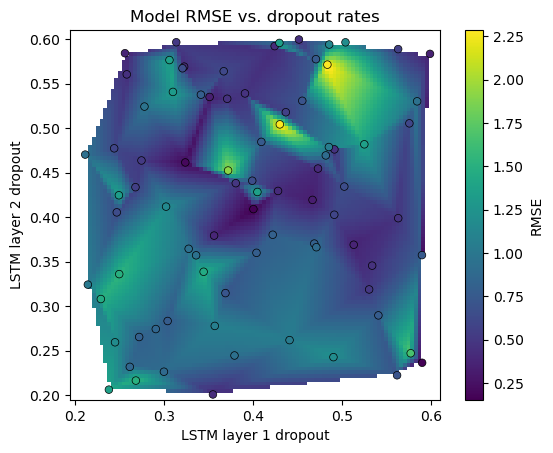

In [13]:
x = convergent.loc[:, "dropout_0"].to_numpy()
y = convergent.loc[:, "dropout_1"].to_numpy()
min_coord = 0.195 #min((min(x), min(y)))
max_coord = 0.61 #max((max(x), max(y)))
grid_x, grid_y = np.mgrid[min_coord:max_coord:100j, min_coord:max_coord:100j]
points = list(zip(x, y))
vals = convergent.loc[:, "rmse"]
grid_z = griddata(points, vals, (grid_x, grid_y), method="linear")
plt.imshow(grid_z.T, extent=(min_coord, max_coord, min_coord, max_coord), origin="lower")
plt.scatter(convergent.loc[:, "dropout_0"], convergent.loc[:, "dropout_1"], s=30, c=convergent.loc[:, "rmse"], marker="o", edgecolor="black", linewidth=0.5)
plt.xlabel("LSTM layer 1 dropout")
plt.ylabel("LSTM layer 2 dropout")
plt.colorbar(label="RMSE")
plt.title("Model RMSE vs. dropout rates")

In [14]:
reg = LinearRegression()

Text(0, 0.5, 'RMSE')

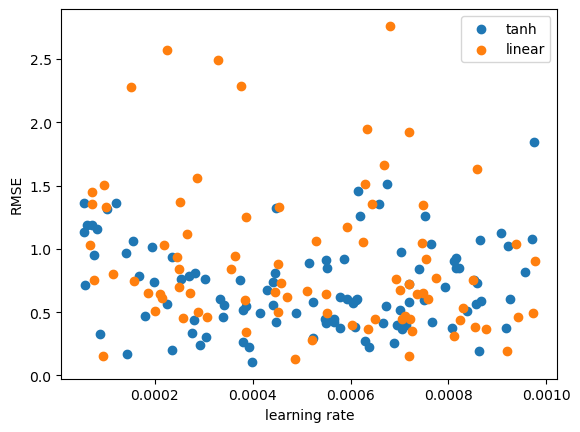

In [17]:
acts = df["activation"].unique()
for act in acts:
    x = df.loc[df["activation"] == act, "lr"]
    y = df.loc[df["activation"] == act, "rmse"]
    plt.scatter(x, y, label=act)
plt.legend()
plt.xlabel("learning rate")
plt.ylabel("RMSE")
#plt.xscale("log")

Text(0, 0.5, 'RMSE')

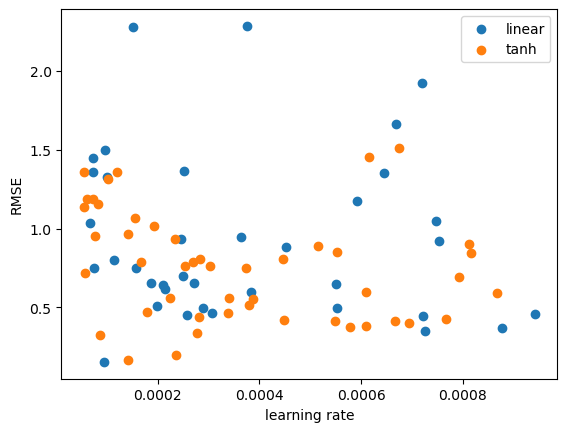

In [18]:
acts = convergent["activation"].unique()
for act in acts:
    plt.scatter(convergent.loc[convergent["activation"] == act, "lr"], convergent.loc[convergent["activation"] == act, "rmse"], label=act)
plt.legend()
plt.xlabel("learning rate")
plt.ylabel("RMSE")
#plt.xscale("log")

Text(0, 0.5, 'RMSE')

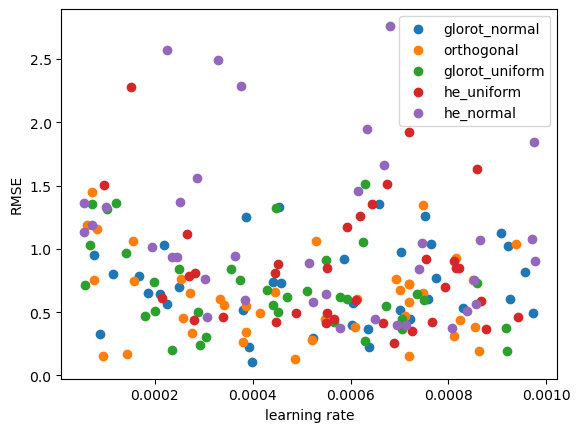

In [20]:
inits = df["kernel_initializer_0"].unique()
for init in inits:
    plt.scatter(df.loc[df["kernel_initializer_0"] == init, "lr"], df.loc[df["kernel_initializer_0"] == init, "rmse"], label=init)
plt.legend()
plt.xlabel("learning rate")
plt.ylabel("RMSE")
#plt.xscale("log")

Text(0, 0.5, 'RMSE')

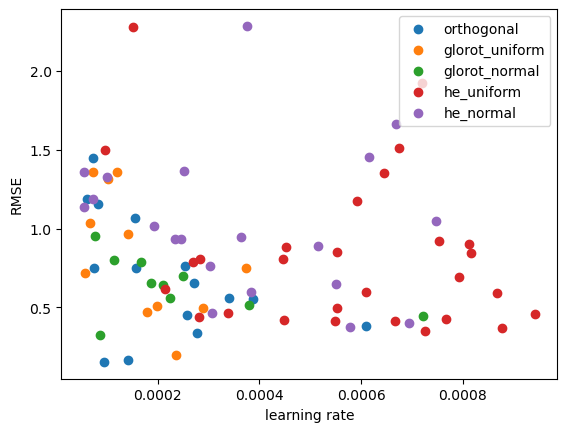

In [21]:
inits = convergent["kernel_initializer_0"].unique()
for init in inits:
    plt.scatter(convergent.loc[convergent["kernel_initializer_0"] == init, "lr"], convergent.loc[convergent["kernel_initializer_0"] == init, "rmse"], label=init)
plt.legend()
plt.xlabel("learning rate")
plt.ylabel("RMSE")
#plt.xscale("log")

Text(0, 0.5, 'RMSE')

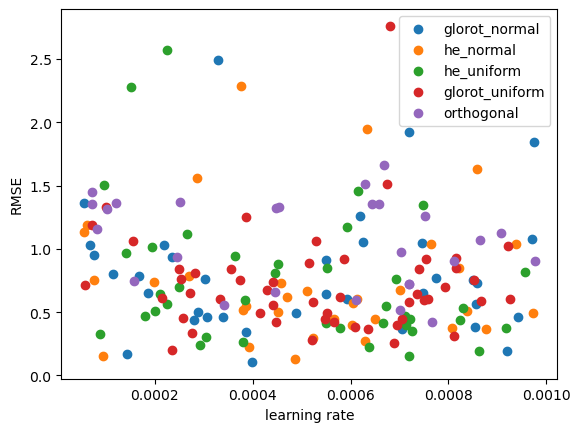

In [22]:
inits = df["kernel_initializer_1"].unique()
for init in inits:
    plt.scatter(df.loc[df["kernel_initializer_1"] == init, "lr"], df.loc[df["kernel_initializer_1"] == init, "rmse"], label=init)
plt.legend()
plt.xlabel("learning rate")
plt.ylabel("RMSE")

Text(0, 0.5, 'RMSE')

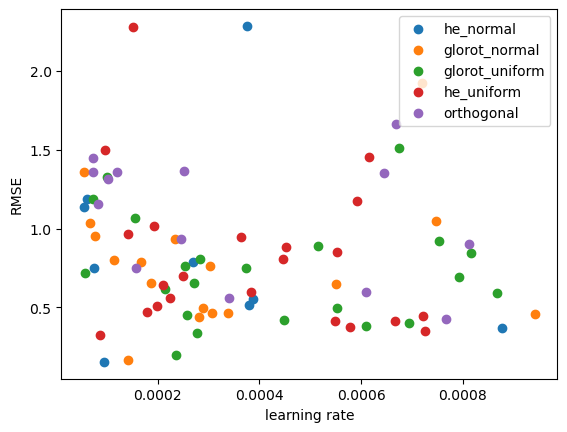

In [23]:
inits = convergent["kernel_initializer_1"].unique()
for init in inits:
    plt.scatter(convergent.loc[convergent["kernel_initializer_1"] == init, "lr"], convergent.loc[convergent["kernel_initializer_1"] == init, "rmse"], label=init)
plt.legend()
plt.xlabel("learning rate")
plt.ylabel("RMSE")
#plt.xscale("log")

Text(0.5, 1.0, 'Model RMSE vs. recurrent dropout rates')

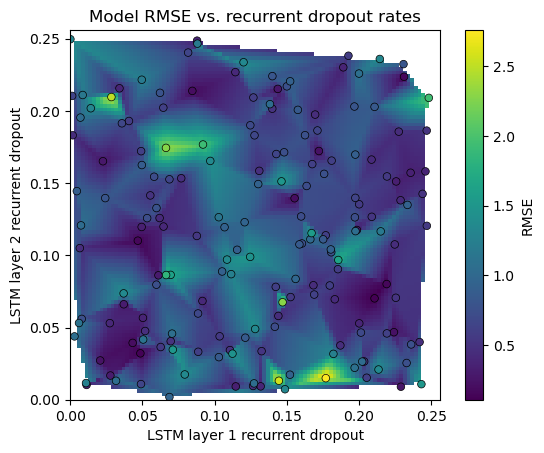

In [24]:
x = df.loc[:, "recurrent_dropout_0"].to_numpy()
y = df.loc[:, "recurrent_dropout_1"].to_numpy()
min_coord = 0 #min((min(x), min(y)))
max_coord = 0.256 #max((max(x), max(y)))
grid_x, grid_y = np.mgrid[min_coord:max_coord:100j, min_coord:max_coord:100j]
points = list(zip(x, y))
vals = df.loc[:, "rmse"]
grid_z = griddata(points, vals, (grid_x, grid_y), method="linear")
plt.imshow(grid_z.T, extent=(min_coord, max_coord, min_coord, max_coord), origin="lower")
plt.scatter(df.loc[:, "recurrent_dropout_0"], df.loc[:, "recurrent_dropout_1"], s=30, c=df.loc[:, "rmse"], marker="o", edgecolor="black", linewidth=0.5)
plt.xlabel("LSTM layer 1 recurrent dropout")
plt.ylabel("LSTM layer 2 recurrent dropout")
plt.colorbar(label="RMSE")
plt.title("Model RMSE vs. recurrent dropout rates")

Text(0.5, 1.0, 'Model RMSE vs. recurrent dropout rates')

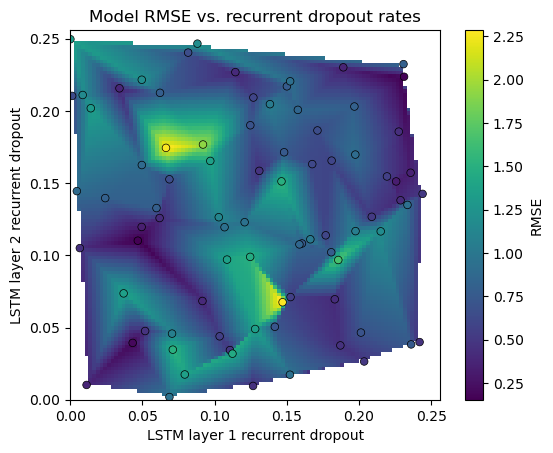

In [25]:
x = convergent.loc[:, "recurrent_dropout_0"].to_numpy()
y = convergent.loc[:, "recurrent_dropout_1"].to_numpy()
min_coord = 0 #min((min(x), min(y)))
max_coord = 0.256 #max((max(x), max(y)))
grid_x, grid_y = np.mgrid[min_coord:max_coord:100j, min_coord:max_coord:100j]
points = list(zip(x, y))
vals = convergent.loc[:, "rmse"]
grid_z = griddata(points, vals, (grid_x, grid_y), method="linear")
plt.imshow(grid_z.T, extent=(min_coord, max_coord, min_coord, max_coord), origin="lower")
plt.scatter(convergent.loc[:, "recurrent_dropout_0"], convergent.loc[:, "recurrent_dropout_1"], s=30, c=convergent.loc[:, "rmse"], marker="o", edgecolor="black", linewidth=0.5)
plt.xlabel("LSTM layer 1 recurrent dropout")
plt.ylabel("LSTM layer 2 recurrent dropout")
plt.colorbar(label="RMSE")
plt.title("Model RMSE vs. recurrent dropout rates")

Text(0, 0.5, 'RMSE')

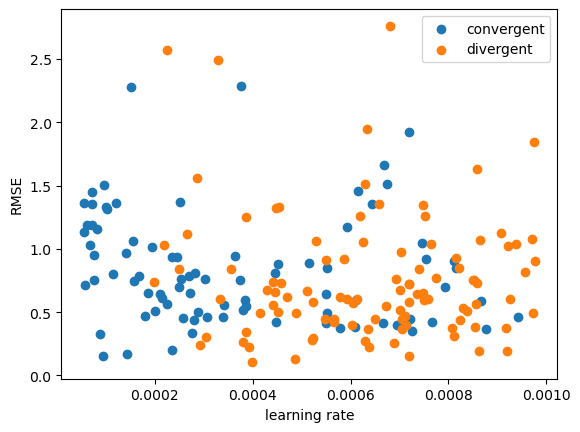

In [27]:
inits = df["kernel_initializer_1"].unique()
plt.scatter(convergent["lr"], convergent["rmse"], label="convergent")
plt.scatter(divergent["lr"], divergent["rmse"], label="divergent")
plt.legend()
plt.xlabel("learning rate")
plt.ylabel("RMSE")

In [28]:
convergent[:15]

,activation,kernel_initializer_0,dropout_0,recurrent_dropout_0,dropout_1,recurrent_dropout_1,kernel_initializer_1,lr,trial id,rmse,mse,best step,total dropout
2,linear,orthogonal,0.400637,0.046802,0.409050,0.110162,he_normal,0.000095,180,0.154016,0.023721,39,0.809687
4,tanh,orthogonal,0.590092,0.231202,0.236492,0.223709,glorot_normal,0.000143,149,0.167694,0.028121,39,0.826584
7,tanh,glorot_uniform,0.324163,0.043207,0.461416,0.039362,glorot_uniform,0.000236,131,0.199317,0.039727,39,0.785579
18,tanh,glorot_normal,0.467001,0.225720,0.419365,0.151199,he_uniform,0.000088,037,0.325557,0.105987,39,0.886366
19,tanh,orthogonal,0.351419,0.049443,0.534962,0.119663,glorot_uniform,0.000277,022,0.335495,0.112557,35,0.886381
21,linear,he_uniform,0.598897,0.235722,0.583343,0.157204,he_uniform,0.000726,069,0.347338,0.120644,33,1.182239
22,linear,he_uniform,0.513257,0.189095,0.369031,0.230235,he_normal,0.000878,085,0.368360,0.135689,32,0.882288
26,tanh,he_normal,0.256417,0.011284,0.584057,0.010238,he_uniform,0.000578,059,0.376076,0.141433,39,0.840473
28,tanh,orthogonal,0.356480,0.034078,0.379290,0.215714,glorot_uniform,0.000609,086,0.380829,0.145031,36,0.735770
31,tanh,he_normal,0.473146,0.091540,0.454556,0.068385,glorot_uniform,0.000694,150,0.400419,0.160335,32,0.927702
